In [1]:
from osgeo import gdal, gdal_array, osr, ogr
import numpy as np
import rasterio
import pyproj
from affine import Affine
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from rasterio.features import shapes

In [3]:
## land cover data
# dataset = gdal.Open('../../../zip_extract/Land_Cover/NYC_2017_LiDAR_LandCover.img')
geotransform = dataset.GetGeoTransform()
band = dataset.GetRasterBand(1)

## catch basin data
cb_data = ogr.Open('../../../catch_basins/DEPCatchbasins/DEPCATCHBASINS.dbf')
layer = cb_data.GetLayer()
cb_ref = layer.GetExtent()

In [4]:
# get offset relative to lc 
lc_origin = (geotransform[0],geotransform[3])
cb_origin = (cb_ref[0],cb_ref[3])
offset_ft = (cb_origin[0]-lc_origin[0], cb_origin[1]-lc_origin[1])
offset_pix = (int(offset_ft[0]*2),int(offset_ft[1]*2))


print('Land cover top left georef:',lc_origin)
print('Catch basin top left georef:', cb_origin)
print(f'CB is shifted by {offset_ft} ft')
print(f'Array top left offset: {offset_pix} pixels (array elements)')

Land cover top left georef: (912286.93, 273618.3)
Catch basin top left georef: (913346.4203000069, 271705.03180000186)
CB is shifted by (1059.4903000068152, -1913.2681999981287) ft
Array top left offset: (2118, -3826) pixels (array elements)


In [5]:
def get_lat_long_arrays(band, x_size, y_size, x_offset = 0, y_offset = 0, proj_from = pyproj.Proj(2263), proj_to = pyproj.Proj(proj = 'latlong')): 
    lc_array = gdal_array.BandReadAsArray(band, x_offset, y_offset, x_size, y_size) 
    cols, rows = np.meshgrid(np.arange(x_size), np.arange(y_size))
    rc_en = lambda r,c : (geotransform[0] + (x_offset + c + 0.5) * geotransform[1], geotransform[3] + (y_offset + r + 0.5) * geotransform[5])
    eastings, northings = np.vectorize(rc_en, otypes = [float, float])(rows, cols)
    transformer = pyproj.Transformer.from_proj(proj_from, proj_to)
    longs, lats = transformer.transform(eastings, northings)
    print(f'Land cover values in sample: {np.unique(lc_array)}')
    print(f'Area of sample: {x_size*y_size/4} sq ft')
    print(f'Total pixels (observations) in sample: {x_size*y_size}')
    return lats, longs

def get_coords_from_lat_long(lat, long, proj_from = pyproj.Proj(2263), proj_to = pyproj.Proj(proj = 'latlong')):
    transformer = pyproj.Transformer.from_proj(proj_to, proj_from)
    eastings, northings = transformer.transform(long, lat)
    x = int((eastings - geotransform[0])/geotransform[1]-0.5)
    y = int((northings - geotransform[3])/geotransform[5]-0.5)
    return x, y

def get_array_lat_long_dim(band, lat, long, length, height):
    x_offset, y_offset = get_coords_from_lat_long(lat, long)
    lc_array = gdal_array.BandReadAsArray(band, x_offset, y_offset, length*2, height*2)
    return lc_array

In [6]:
#ex - pick a point off google maps (40.727023, -74.014026)
# pick desired rectangle size 2000ft x 1000 ft

lat = np.array(40.727023)
long = np.array(-74.014026)
width = 2000
height = 1000
lc_array = get_array_lat_long_dim(band, lat, long, width, height)

#get offset 
x_offset, y_offset = get_coords_from_lat_long(lat, long)

# get polygons for visualizing
results = ({'properties': {'raster_val': v}, 'geometry': s}
           for i, (s, v) in enumerate(
            shapes(lc_array, mask=None,
                   transform=Affine(0.5, 0.0, 912286.93+x_offset/2,0.0, -0.5, 273618.3-y_offset/2))))

#convert to geopandas df
geoms = list(results)
gdf_p  = GeoDataFrame.from_features(geoms, crs = 'EPSG:2263')

In [7]:
lc_array

array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       ...,
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6]], dtype=uint8)

In [8]:
x_offset, y_offset

(136150, 138934)

In [9]:
gdf_p

,geometry,raster_val
0,"POLYGON ((981941.430 204151.300, 981941.430 20...",7.0
1,"POLYGON ((982023.930 204151.300, 982023.930 20...",1.0
2,"POLYGON ((981144.430 204151.300, 981154.430 20...",2.0
3,"POLYGON ((982162.930 204150.300, 982163.430 20...",7.0
4,"POLYGON ((982231.430 204151.300, 982242.930 20...",1.0
...,...,...
602,"POLYGON ((981437.430 203171.800, 981439.930 20...",1.0
603,"POLYGON ((981610.930 203301.800, 981613.430 20...",7.0
604,"POLYGON ((981662.930 203160.800, 981666.430 20...",1.0
605,"POLYGON ((982208.930 203204.800, 982209.930 20...",1.0


<AxesSubplot: >

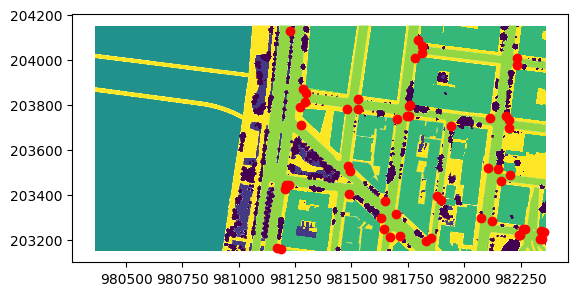

In [22]:
#plot catch basins on land cover 
ax = gdf_p.plot('raster_val',legend = False)
gdf_cb['geometry'].plot(ax=ax, color = 'red')

In [15]:
layer.SetAttributeFilter('POINT_X > 912286.93+{x_offset}/2 AND POINT_X < 912286.93+{x_offset}/2+{width} AND POINT_Y < 273618.3-{y_offset}/2 AND POINT_Y > 273618.3-{y_offset}/2-{height}'.format(x_offset = x_offset, width = width, y_offset = y_offset, height = height))
basin_ind = []
geometry_ll = []
geometry = []
for feature in layer:
    basin_ind.append(1)
    #geometry_ll.append(Point(feature.LATITUDE,feature.LONGITUDE))
    geometry.append(Point(feature.POINT_X, feature.POINT_Y))

In [17]:
df = pd.DataFrame(zip(basin_ind),columns = ['basin_ind'])
gdf_cb = GeoDataFrame(df, crs = 'EPSG:2263', geometry = geometry)
gdf_cb.head()

,basin_ind,geometry
0,1,POINT (981528.321 203827.044)
1,1,POINT (981527.250 203779.068)
2,1,POINT (981479.392 203781.850)
3,1,POINT (981702.426 203735.006)
4,1,POINT (981754.703 203751.800)


## Function for plotting catch basins over land cover on user-specified rectangle

In [42]:
def plot_lc_cb(lat, long, width, height):
    #get land cover array from lat long and dimensions
    lc_array = get_array_lat_long_dim(band, lat, long, width, height)
    #get pixel offset
    x_offset, y_offset = get_coords_from_lat_long(lat, long)
    #get polygons with offset factored in
    results = ({'properties': {'raster_val': v}, 'geometry': s} for i, (s, v) in enumerate(shapes(lc_array, mask=None, transform=Affine(0.5, 0.0, 912286.93+x_offset/2,0.0, -0.5, 273618.3-y_offset/2))))
    geoms = list(results)
    #create geopandas df for land cover polygons
    gdf_p  = GeoDataFrame.from_features(geoms, crs = 'EPSG:2263')
    #filter catch basin data based on offset and dimensions
    layer.SetAttributeFilter('POINT_X > 912286.93+{x_offset}/2 AND POINT_X < 912286.93+{x_offset}/2+{width} AND POINT_Y < 273618.3-{y_offset}/2 AND POINT_Y > 273618.3-{y_offset}/2-{height}'.format(x_offset = x_offset, width = width, y_offset = y_offset, height = height))
    #extract feature attributes
    basin_ind = []
    geometry_ll = []
    geometry = []
    for feature in layer:
        basin_ind.append(1)
        #geometry_ll.append(Point(feature.LATITUDE,feature.LONGITUDE))
        geometry.append(Point(feature.POINT_X, feature.POINT_Y))
    #create geopandas df for catch basins
    df = pd.DataFrame(zip(basin_ind),columns = ['basin_ind'])
    gdf_cb = GeoDataFrame(df, crs = 'EPSG:2263', geometry = geometry)
    #plot land cover, plot catch basins with axis set to land cover axis
    ax = gdf_p.plot('raster_val',legend = False)
    gdf_cb['geometry'].plot(ax=ax, color = 'red', markersize = 3)

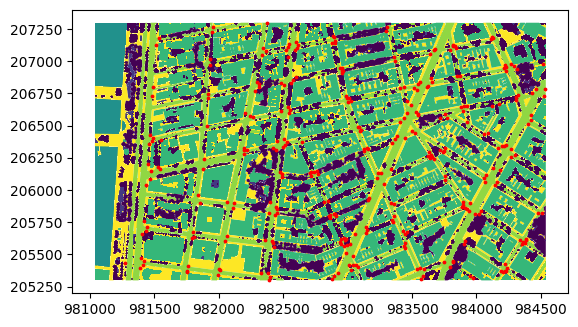

In [43]:
plot_lc_cb(np.array(40.735661),np.array(-74.011588),3500,2000)

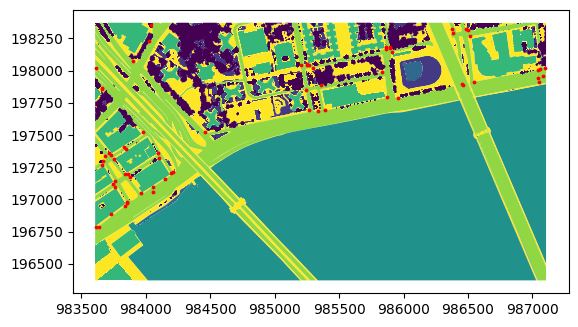

In [44]:
plot_lc_cb(np.array(40.711157), np.array(-74.002321), 3500, 2000)